In [1]:
# 运行此段做数据准备
import cv2
import numpy as np
import matplotlib.pyplot as plt

srcImg = cv2.imread('../images/flower.png', 0)
rows, cols = srcImg.shape

In [2]:
'''
# 运动模糊
'''

# 定义运动方向和距离
angle = 45
distance = 10
# 计算运动矩阵,包括旋转和平移运动
motion_mat = cv2.getRotationMatrix2D((distance // 2, distance // 2), angle, 1)
tx = distance * np.cos(angle * np.pi / 180)
ty = distance * np.sin(angle * np.pi / 180)
# 此处-1是为了配合下面求卷积核时kernel_scale = distance * 2 - 1，确保平移后不丢失有效值
motion_mat[0, 2] += tx - 1
motion_mat[1, 2] += ty - 1


# 应用运动矩阵,kernel_size取决于distance，这决定了我们将多少像素叠加在一起
# 卷积核将运动方向上的像素叠加后取平均，运动方向的的像素由插值法取得
# 为了保证在运动方向上能取到相应的像素数，卷积核到中心到边缘的距离要等于运动距离，卷积核大小应该为距离的两倍，为了方便后续卷积运算，-1使其为奇数
kernel_scale = distance * 2 - 1
kernel_size = (kernel_scale, kernel_scale)
motion_blur_kernel = np.zeros(kernel_size)
# 先假设运动模糊在水平方向
motion_blur_kernel[int(kernel_scale // 2), :] = np.ones(kernel_scale)
# 值得注意的是这里cv2.warpAffine输入参数dsize=kernel_size，严格意义上输入应该是kernel_size的倒序
motion_blur_kernel = cv2.warpAffine(motion_blur_kernel, motion_mat, kernel_size)
motion_blur_kernel = motion_blur_kernel / kernel_scale
# 此处确保卷积核权值和为1，小于或大于1时会使图片偏暗或偏亮
motion_blur_kernel = motion_blur_kernel / np.sum(motion_blur_kernel)
img_motion_blur = cv2.filter2D(srcImg, -1, motion_blur_kernel)

# 为图像添加恒功率噪声
# 定义噪声均值和标准差，高斯白噪声的平均功率等于方差
mean = 0
sigma = 50
noise = np.zeros(srcImg.shape, np.uint8)
cv2.randn(noise, mean, sigma)
img_noisy = cv2.add(img_motion_blur, noise)

# 显示图像
cv2.imshow('Image', srcImg)
cv2.imshow('Motion Blur', img_motion_blur)
cv2.imshow('Add Gaussian Noise based on Motion Blur', img_noisy)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 至此为已完成部分

Text(0.5, 1.0, 'Wiener Filter')

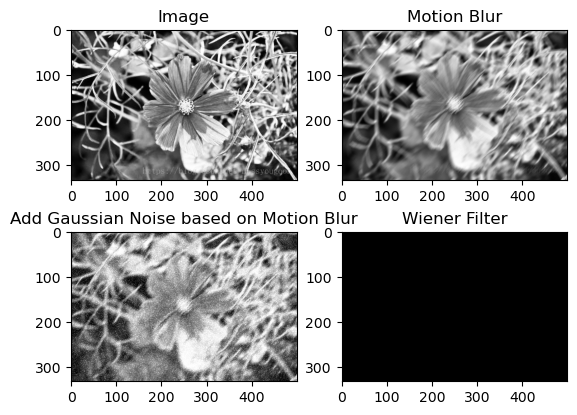

In [9]:
# 此部分未完成，结果不符合预期
'''
# 维纳滤波
'''
# 计算噪声功率谱和图像功率谱
f = np.fft.fft2(img_noisy)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20 * np.log(np.abs(fshift))
noise_spectrum = 20 * np.log(np.abs(np.fft.fftshift(np.fft.fft2(noise)) ** 2))

# 计算维纳滤波器的频率响应
K = 0.01
H = np.conj(fshift) / (np.abs(fshift) ** 2 + K * np.abs(np.fft.fftshift(np.fft.fft2(noise))) ** 2)
# 对图像进行傅里叶变换，并将维纳滤波器的频率响应应用于频域图像
f_filtered = H * fshift
img_filtered = np.abs(np.fft.ifft2(np.fft.ifftshift(f_filtered)))

# 显示图像
figure2 = plt.figure()
plt.subplot(221)
plt.imshow(srcImg, "gray")
plt.title('Image')
plt.subplot(222)
plt.imshow(img_motion_blur, "gray")
plt.title('Motion Blur')
plt.subplot(223)
plt.imshow(img_noisy, "gray")
plt.title('Add Gaussian Noise based on Motion Blur')
plt.subplot(224)
plt.imshow(img_filtered, "gray")
plt.title('Wiener Filter')